In [127]:
import pandas as pd
import os
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)



In [128]:
seg_folder = 'outputs/metrics_ondri_cerebra/'
metric_df = []
seg_files = os.listdir(seg_folder)
for file in seg_files:
    metric_df.append(pd.read_csv(seg_folder + file))

metric_df = pd.concat(metric_df)
metric_df['SUBJECT'] = [x.split('.')[:-1][0] for x in seg_files]

metric_df = metric_df.dropna(axis=1, how='all')


In [129]:
delete_cols = metric_df.columns[metric_df.columns.str.contains('MII') | metric_df.columns.str.contains('mean')]
metric_df = metric_df.drop(delete_cols, axis=1)

In [130]:
nvox_cols = metric_df.columns[metric_df.columns.str.contains('nvox')]
metric_df[nvox_cols] = np.asarray(metric_df[nvox_cols])/np.expand_dims(metric_df['TBV-voxel'], axis=-1)

In [131]:
clinical_df = pd.read_csv('data/summary/ONDRI_summary.csv')

In [132]:
merged = pd.merge(clinical_df[['SUBJECT', 'COHORT']], metric_df, on='SUBJECT')

In [133]:
merged.columns = [x.replace('Left', 'Tempxxx') for x in merged.columns]
merged.columns = [x.replace('Right', 'Left') for x in merged.columns]
merged.columns = [x.replace('Tempxxx', 'Right') for x in merged.columns]

In [134]:
if not os.path.exists('outputs/analysis'):
    os.makedirs('outputs/analysis')

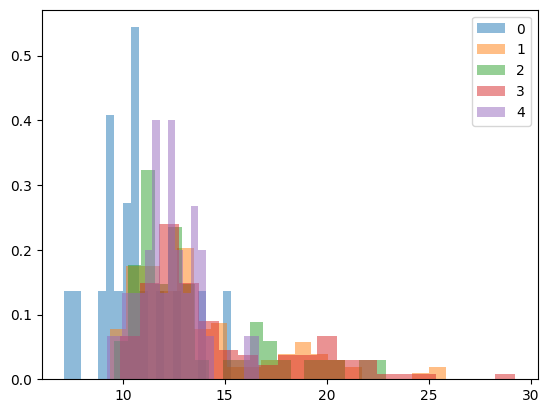

In [135]:
# import matplotlib.pyplot as plt
# for x in range(5):
#     plt.hist(features[labels==x]['MAD_Brain'], alpha=0.5, bins=20, label=str(x), density=True)
# plt.legend()

In [136]:
# train models
from sklearn.model_selection import KFold
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  recall_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix as confusion_matrix_fn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import ttest_ind, f_oneway as anova
import shap





for version in 'vol', 'texture', 'both':
    classification_accuracy_df = []

    labelmap = {'HC': 0, 'ADMCI': 1, 'FTD': 2, 'PD': 3, 'ALS': 4}

    merged_select = merged[merged['COHORT'].isin(list(labelmap.keys()))]
    features = merged_select[list(filter(lambda x: x not in [ 'SUBJECT', 'COHORT'], merged_select.columns))]
    features = features.dropna(axis=1, how='any')
    
    if version == 'vol':
        vol_cols = list(filter(lambda x: 'nvox' in x, features.columns))
        features = features[vol_cols]
    elif version == 'texture':
        mii_cols = list(filter(lambda x: 'MAD' in x, features.columns)) 
        features = features[mii_cols]
    #features = features.drop(columns=['TBV-voxel'])

    labels = merged['COHORT']
    labels = merged_select['COHORT'].map(labelmap)

    kf = KFold(n_splits=10, shuffle=True, random_state=49)

    val_predictions_lr = np.zeros((labels.shape[0], 5))
    val_predictions_rf = np.zeros((labels.shape[0], 5))
    models_lr = []
    shap_lr = []
    models_rf =[]
    shap_rf = []

    for train_idx, val_idx in kf.split(features):
        train_features = features.iloc[train_idx]
        train_labels = labels.iloc[train_idx]
        val_features = features.iloc[val_idx]
        val_labels = labels.iloc[val_idx]

        # ---------------------------------------------------------------------------------------------------------------------------------------------
        # Random Forest training
        model = BalancedRandomForestClassifier(random_state=0)
        model.fit(train_features, train_labels)

        explainer = shap.TreeExplainer(model, data=val_features)
        shap_values = explainer.shap_values(val_features, check_additivity=False)

        shap_rf.append(shap_values)
        models_rf.append(model)
        val_predictions_rf[val_idx] = model.predict_proba(val_features)
    
    print(classification_report(labels, np.argmax(val_predictions_rf, axis=-1)))
    
    confusion_matrix = confusion_matrix_fn(labels, np.argmax(val_predictions_rf, axis=-1))
    print(np.round(confusion_matrix/np.sum(confusion_matrix, axis=-1)[:, np.newaxis],2))

    coef_df = pd.DataFrame()
    coef_df['feature'] = features.columns
    mean_imps = np.mean(np.array([model.feature_importances_ for model in models_rf]), axis=0)
    mean_shaps = np.mean(np.abs(np.concatenate([shap_values[1] for shap_values in shap_rf])), axis=0)

    coef_df['shap'] = mean_shaps
    coef_df['imps'] = mean_imps
    coef_df['p'] = [anova(*[features[x][labels==y] for y in [0,1,2,3,4]]).pvalue for x in coef_df['feature']]
    coef_df = coef_df.sort_values(by='shap', ascending=False)
    coef_df.to_csv('outputs/analysis/multiclass_%s.csv' % (version), index=False)


        # coef_df = pd.DataFrame()
        # coef_df['feature'] = features.columns
        # mean_imps = np.mean(np.array([model.feature_importances_ for model in models_rf]), axis=0)
        # mean_shaps = np.mean(np.abs(np.concatenate([shap_values[1] for shap_values in shap_rf])), axis=0)

        # coef_df['shap'] = mean_shaps
        # coef_df['imps'] = mean_imps
        # coef_df['mean_percent'] = [(np.mean(features[x][labels==1])/np.mean(features[x][labels==0])) for x in coef_df['feature']]
        # coef_df['p'] = [ttest_ind(features[x][labels==0], features[x][labels==1]).pvalue for x in coef_df['feature']]
        # coef_df = coef_df.sort_values(by='shap', ascending=False)
        # coef_df.to_csv('outputs/analysis/%s_vs_%s_%s.csv' % (comparison[0], comparison[1], version), index=False)


        # confusion_matrix = confusion_matrix_fn(labels, np.argmax(val_predictions_rf, axis=-1))

        # recall_0 = confusion_matrix[0, 0]/ (confusion_matrix[0, 0] + confusion_matrix[0, 1]) # (yes this agrees with sklearn confusion_matrix)
        # recall_1 = confusion_matrix[1, 1]/ (confusion_matrix[1, 0] + confusion_matrix[1, 1])

        # classification_accuracy_df.append(pd.Series({'comparison': '%s vs %s' % (comparison[0], comparison[1]), 
        #                                             'auc': roc_auc_score(labels, val_predictions_rf[:, 1]),
        #                                             'Recall 0': recall_0,
        #                                             'Recall 1': recall_1,
        #                                             })) 
                                                    
                                                                    
    # classification_accuracy_df = pd.DataFrame(classification_accuracy_df)

    # classification_accuracy_df['Recall 0'] = np.round(classification_accuracy_df['Recall 0'], 2)
    # classification_accuracy_df['Recall 1'] = np.round(classification_accuracy_df['Recall 1'], 2)
    # classification_accuracy_df['auc'] = np.round(classification_accuracy_df['auc'], 2)
    # classification_accuracy_df.to_csv('outputs/analysis/classification_accuracy_%s.csv' % version, index=False)

              precision    recall  f1-score   support

           0       0.16      0.50      0.24        18
           1       0.36      0.22      0.27       125
           2       0.25      0.39      0.31        51
           3       0.49      0.27      0.35       138
           4       0.21      0.45      0.29        40

    accuracy                           0.30       372
   macro avg       0.29      0.37      0.29       372
weighted avg       0.37      0.30      0.30       372

[[0.5  0.   0.06 0.17 0.28]
 [0.1  0.22 0.27 0.22 0.19]
 [0.16 0.24 0.39 0.08 0.14]
 [0.14 0.23 0.14 0.27 0.22]
 [0.2  0.12 0.12 0.1  0.45]]
              precision    recall  f1-score   support

           0       0.21      0.56      0.31        18
           1       0.46      0.25      0.32       125
           2       0.28      0.47      0.35        51
           3       0.53      0.34      0.41       138
           4       0.31      0.62      0.41        40

    accuracy                           0.37 

p
5.053960e-15
4.075563e-15
1.689646e-09
9.444900e-13
4.847761e-07
5.884894e-11
3.919277e-09
1.701413e-07
1.975883e-13
8.733874e-06
